In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from scipy.interpolate import BSpline
from sklearn.utils import resample

%matplotlib inline
warnings.filterwarnings('ignore')

np.random.seed(42)

In [7]:
Z = np.array([
    [ 0.04217926,  0.45348837], [ 0.07381371,  0.12790698], [ 0.10544815,  0.25581395], [ 0.14762742,  0.36046512],
    [ 0.31634446,  0.3255814 ], [ 0.37434095,  0.53488372], [ 0.43233743,  1.1744186 ], [ 0.53778559,  1.10465116],
    [ 0.64850615,  1.03488372], [ 0.64850615,  0.8255814 ], [ 0.6801406 ,  0.80232558], [ 0.71704745,  0.68604651],
    [ 0.78031634,  0.8255814 ], [ 0.86467487,  0.74418605], [ 1.03866432,  1.03488372], [ 0.35325132,  3.47674419],
    [ 0.84358524,  2.26744186], [ 0.8172232 ,  1.47674419], [ 1.42355009,  3.1627907 ], [ 1.03866432,  0.59302326],
    [ 0.95957821,  0.39534884], [ 1.02811951,  0.25581395], [ 1.31810193, -0.06976744], [ 1.32864675, -0.6627907 ],
    [ 1.33391916, -0.88372093], [ 1.4340949 , -0.63953488], [ 1.49209139, -1.02325581], [ 1.59753954, -1.04651163],
    [ 1.73989455, -1.43023256], [ 1.96133568, -0.6627907 ], [ 1.95079086, -0.3372093 ], [ 2.01933216,  0.06976744],
    [ 2.07732865,  0.        ], [ 2.11950791,  0.37209302], [ 2.14586995,  0.40697674], [ 2.11950791,  0.86046512],
    [ 2.24077329,  1.25581395], [ 2.30931459,  1.63953488], [ 2.456942  ,  2.37209302], [ 2.4516696 ,  3.        ],
    [ 2.55711775,  3.19767442], [ 2.60456942,  3.1627907 ], [ 2.66783831,  3.11627907], [ 2.5940246 ,  2.74418605],
    [ 2.68892794,  2.80232558], [ 2.77855888,  3.11627907], [ 2.81019332,  2.74418605], [ 2.77328647,  5.04651163],
    [ 2.95782074,  1.87209302], [ 2.98945518,  1.51162791]])
X, Y = Z[:,0], Z[:,1]

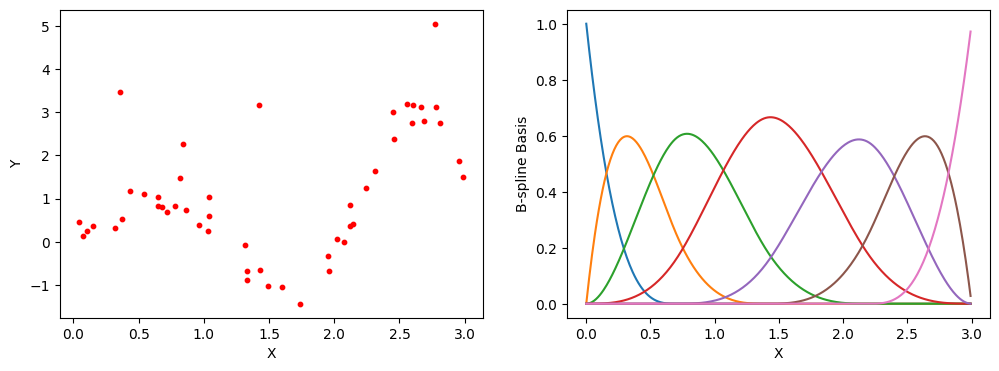

In [8]:
def B(x, k, i, t):
    if k == 0:
        return 1.0 if t[i] <= x < t[i+1] else 0.0
    if t[i+k] == t[i]:
        c1 = 0.0
    else:
        c1 = (x - t[i])/(t[i+k] - t[i]) * B(x, k-1, i, t)
    if t[i+k+1] == t[i+1]:
        c2 = 0.0
    else:
        c2 = (t[i+k+1] - x)/(t[i+k+1] - t[i+1]) * B(x, k-1, i+1, t)
    return c1 + c2

def expand_basis(x):
    x_exp = np.zeros(shape=(x.shape[0], 7))
    t = np.array([0., 0., 0., 0., 0.7, 1.4, 2.2, 3., 3., 3., 3.])

    for n in range(7):
        for i in range(x.shape[0]):
            x_exp[i, n] = B(x[i], 3, n, t)

    return x_exp

plt.figure(figsize=(12,4))

plt.subplot(121)
plt.scatter(X, Y, color='red', s=10)
plt.xlabel('X')
plt.ylabel("Y")

plt.subplot(122)
xx = np.linspace(0, 3, 400)[:-1]
xx_exp = expand_basis(xx)
for n in range(7):
    plt.plot(xx, xx_exp[:,n])

plt.xlabel("X")
plt.ylabel("B-spline Basis")

plt.show()

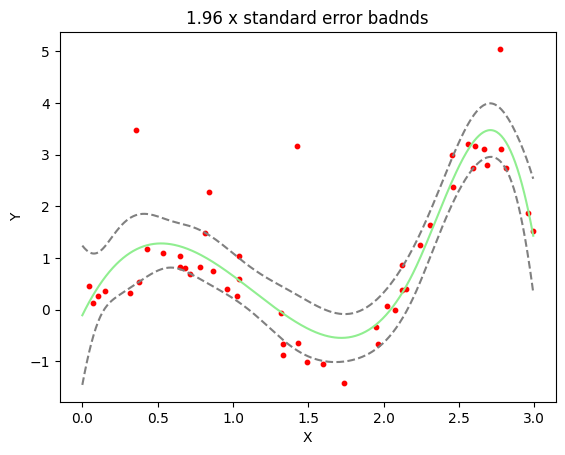

In [9]:
H = expand_basis(X)
hat_beta  = np.linalg.inv(H.T @ H)  @ H.T @ Y
Y_pred = H @ hat_beta

sigma_hat_sq = np.sum((Y - Y_pred)**2)/len(X)
hat_beta_var = np.linalg.inv(H.T @ H) * sigma_hat_sq

yy_pred = xx_exp @ hat_beta
se_hat = np.array([np.sqrt(h.T @ np.linalg.inv(H.T @ H) @ h * sigma_hat_sq) for h in xx_exp])

plt.scatter(X, Y, color='red', s=10)
plt.xlabel('X')
plt.ylabel("Y")
plt.plot(xx, yy_pred, color='lightgreen')
plt.plot(xx, yy_pred + 1.96 * se_hat, '--', color='gray')
plt.plot(xx, yy_pred - 1.96 * se_hat, '--', color='gray')

plt.title("1.96 x standard error badnds")
plt.show()

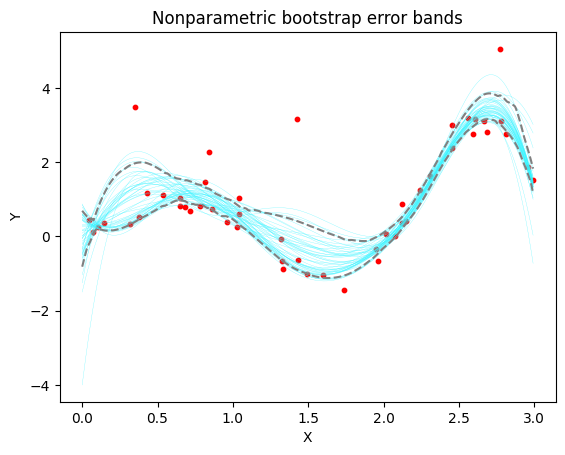

In [ ]:
yy_preds = np.zeros((len(xx), 50))
for b in range(50):
    X_re, Y_re = resample(X,Y)
    H_re = expand_basis(X_re)
    hat_beta_re  = np.linalg.inv(H_re.T @ H_re)  @ H_re.T @ Y_re
    Y_pred_re = H_re @ hat_beta_re

    sigma_hat_sq_re = np.sum((Y_re - Y_pred_re)**2)/len(X)
    hat_beta_var_re = np.linalg.inv(H_re.T @ H_re) * sigma_hat_sq_re

    yy_pred_re = xx_exp @ hat_beta_re
    yy_preds[:,b] = yy_pred_re
    plt.plot(xx, yy_pred_re, color='#36f5ff', linewidth = 0.2, alpha=0.8)


plt.scatter(X, Y, color='red', s=10)
plt.plot(xx, np.sort(yy_preds,axis=1)[:,4], '--', color='gray')
plt.plot(xx, np.sort(yy_preds,axis=1)[:,-4], '--', color='gray')
plt.xlabel('X')
plt.ylabel("Y")
plt.title("Nonparametric bootstrap error bands")
plt.show()

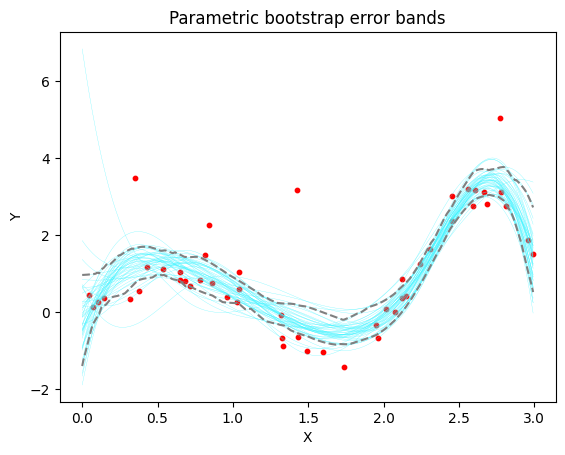

In [11]:
yy_preds_param = np.zeros((len(xx), 50))
for b in range(50):
    re_idx = resample(range(len(X)))
    X_re, Y_re = X[re_idx], Y_pred[re_idx] + np.random.normal(0, np.sqrt(sigma_hat_sq), size=50)

    H_re = expand_basis(X_re)
    hat_beta_re  = np.linalg.inv(H_re.T @ H_re)  @ H_re.T @ Y_re
    Y_pred_re = H_re @ hat_beta_re

    sigma_hat_sq_re = np.sum((Y_re - Y_pred_re)**2)/len(X)
    hat_beta_var_re = np.linalg.inv(H_re.T @ H_re) * sigma_hat_sq_re

    yy_pred_re = xx_exp @ hat_beta_re
    yy_preds_param[:,b] = yy_pred_re
    plt.plot(xx, yy_pred_re, color='#36f5ff', linewidth = 0.2, alpha=0.8)

plt.scatter(X, Y, color='red', s=10)
plt.plot(xx, np.sort(yy_preds_param,axis=1)[:,4], '--', color='gray')
plt.plot(xx, np.sort(yy_preds_param,axis=1)[:,-4], '--', color='gray')
plt.xlabel('X')
plt.ylabel("Y")
plt.title("Parametric bootstrap error bands")
plt.show()

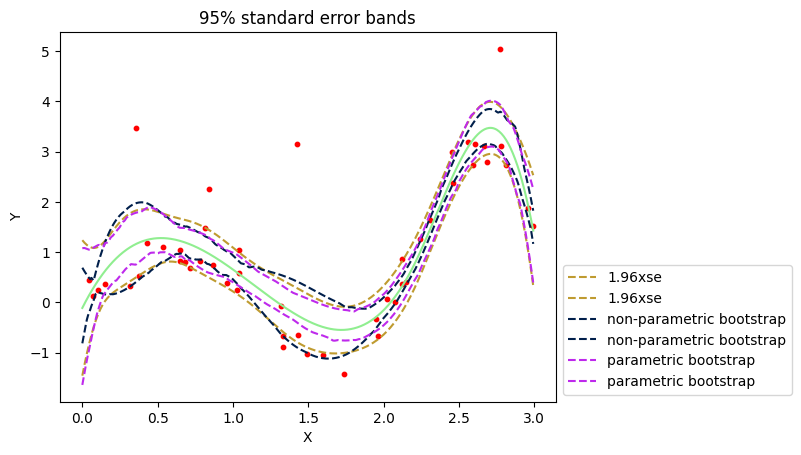

In [ ]:
plt.scatter(X, Y, color='red', s=10)
plt.xlabel('X')
plt.ylabel("Y")
plt.plot(xx, yy_pred, color='lightgreen')
plt.plot(xx, yy_pred + 1.96 * se_hat, '--', color='#bf9b30', label='1.96xse')
plt.plot(xx, yy_pred - 1.96 * se_hat, '--', color='#bf9b30', label='1.96xse')

plt.plot(xx, np.sort(yy_preds,axis=1)[:,4], '--', color='#011f4b', label='non-parametric bootstrap')
plt.plot(xx, np.sort(yy_preds,axis=1)[:,-4], '--', color='#011f4b', label='non-parametric bootstrap')

plt.plot(xx, np.sort(yy_preds_param,axis=1)[:,4], '--',color='#be29ec', label='parametric bootstrap')
plt.plot(xx, np.sort(yy_preds_param,axis=1)[:,-4], '--',color='#be29ec', label='parametric bootstrap')

plt.legend(loc='lower left', bbox_to_anchor=(1.0,0))
plt.title("95% standard error bands")
plt.show()

In [6]:
posterior_expectation_1 = np.array([h.T @ np.linalg.inv(H.T @ H + sigma_hat_sq * np.eye(7)) @ H.T @ Y for h in xx_exp])
posterior_expectation_1000 = np.array([h.T @ np.linalg.inv(H.T @ H + sigma_hat_sq / 1000 * np.eye(7)) @ H.T @ Y for h in xx_exp])

posterior_covariance_1, posterior_covariance_1000  = np.zeros((399, 399)), np.zeros((399, 399))

for i,hi in enumerate(xx_exp):
    for j,hj in enumerate(xx_exp):
        posterior_covariance_1[i, j] = hi.T @ np.linalg.inv(H.T @ H + sigma_hat_sq *np.eye(7)) @ hj * sigma_hat_sq
        posterior_covariance_1000[i, j] = hi.T @ np.linalg.inv(H.T @ H + sigma_hat_sq / 1000 *np.eye(7) ) @ hj * sigma_hat_sq

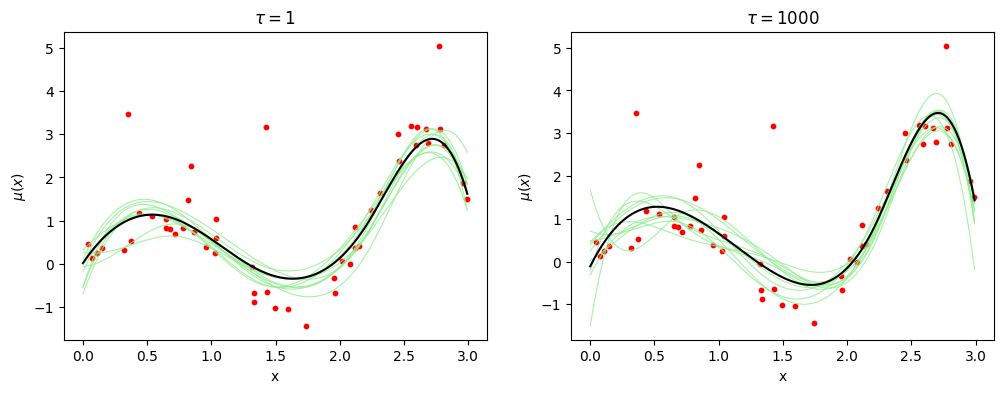

In [ ]:
plt.figure(figsize=(12,4))

plt.subplot(121)
plt.scatter(X, Y, color='red', s=10)
plt.xlabel('x')
plt.ylabel('$\mu(x)$')

for i in range(10):
    yy_pred_bayes = np.random.multivariate_normal(posterior_expectation_1, posterior_covariance_1)
    plt.plot(xx, yy_pred_bayes, color='lightgreen', linewidth = 0.8, alpha=0.8)

plt.plot(xx, posterior_expectation_1, color='black')
plt.title(r'$\tau = 1$')

plt.subplot(122)
plt.scatter(X, Y, color='red', s=10)
plt.xlabel('x')
plt.ylabel('$\mu(x)$')

for i in range(10):
    yy_pred_bayes = np.random.multivariate_normal(posterior_expectation_1000, posterior_covariance_1000)
    plt.plot(xx, yy_pred_bayes, color='lightgreen', linewidth = 0.8, alpha=0.8)

plt.plot(xx, posterior_expectation_1000, color='black')
plt.title(r'$\tau = 1000$')
plt.show()

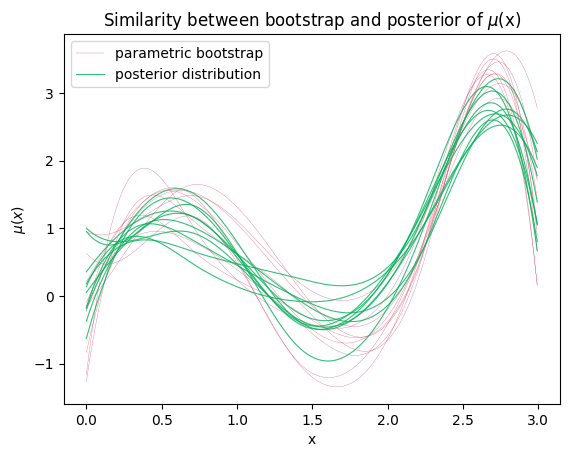

In [12]:
yy_preds_param = np.zeros((len(xx), 10))
for b in range(10):
    re_idx = resample(range(len(X)))
    X_re, Y_re = X[re_idx], Y_pred[re_idx] + np.random.normal(0, np.sqrt(sigma_hat_sq), size=50)

    H_re = expand_basis(X_re)
    hat_beta_re  = np.linalg.inv(H_re.T @ H_re)  @ H_re.T @ Y_re
    Y_pred_re = H_re @ hat_beta_re

    sigma_hat_sq_re = np.sum((Y_re - Y_pred_re)**2)/len(X)
    hat_beta_var_re = np.linalg.inv(H_re.T @ H_re) * sigma_hat_sq_re

    yy_pred_re = xx_exp @ hat_beta_re
    yy_preds_param[:,b] = yy_pred_re
    plt.plot(xx, yy_pred_re, color='#d11141', linewidth = 0.2, alpha=0.8, label = 'parametric bootstrap' if b == 0 else None)

for i in range(10):
    yy_pred_bayes = np.random.multivariate_normal(posterior_expectation_1, posterior_covariance_1)
    plt.plot(xx, yy_pred_bayes, color='#00b159', linewidth = 0.8, alpha=0.8, label='posterior distribution' if i == 0 else None)

plt.title("Similarity between bootstrap and posterior of $\mu$(x)")
plt.xlabel('x')
plt.ylabel('$\mu(x)$')
plt.legend()
plt.show()